# Required Package conda install -c anaconda nltk

In [1]:
%conda install -c anaconda nltk

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda/envs/py39

  added / updated specs:
    - nltk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.07.19 |       h06a4308_0         131 KB  anaconda
    certifi-2022.6.15          |   py39h06a4308_0         156 KB  anaconda
    click-8.0.4                |   py39h06a4308_0         150 KB  anaconda
    nltk-3.7                   |     pyhd3eb1b0_0         1.1 MB  anaconda
    openssl-1.1.1s             |       h0b41bf4_1         1.9 MB  conda-forge
    regex-2022.7.9             |   py39h5eee18b_0         383 KB  anaconda
    tqdm-4.64.0                |   py39h06a4308_0         122 KB  anaconda
    ---------

In [2]:
import nltk

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
from neo4j import GraphDatabase
import json 
import matplotlib.pyplot as plt 
import numpy as np 

In [5]:
graph = GraphDatabase.driver("bolt://neo4j:7687", auth=("neo4j", "test"), encrypted=False)

In [6]:
# clear all existing nodes
with graph.session() as session:
    session.run("MATCH (n) DETACH DELETE n")

### LOADING IN TWEETS

Each tweet is loaded one by one, and for each tweet we first create a node for it. Each tweet only stores it's identifier, the text and the author. After another node for the stats of that tweet is created followed by a linking relationship. Similarly, a node for topic and mentions is created, followed by their respective relation. 

In [7]:
 with open('Raw_Data_Wayne/tweets.json') as file:  
    json_tweets = json.load(file)

def create_tweet_stats(tx, parent_id, stat_obj):#create a node for the stats and links it to the tweet 
    tx.run("MERGE (a:Stats {name :$iden, likes: $likes, retweets: $retweets, replies: $replies, quotes: $quotes})", iden=parent_id, likes=stat_obj['like_count'], retweets=stat_obj['retweet_count'], replies= stat_obj['reply_count'], quotes=stat_obj['quote_count'])
    tx.run("MATCH (a:Tweet {name: $parent_id_tweet})"
           "MATCH (b:Stats {name: $parent_id_child})"
           "MERGE (a)-[r:MY_STATS]->(b)", parent_id_tweet= parent_id, parent_id_child=parent_id)
    
def create_tweet_topics(tx, tweet_id, context_list):#creates a node for the topic and links it to the tweet 
    for entry in context_list:
        tx.run("MERGE (a:Topic {name:$name, t_id:$iden})", name=entry['entity']['name'], iden=entry['entity']['id'])
        tx.run("MATCH (a:Tweet {name: $tweet})" 
               "MATCH (b:Topic {t_id: $iden})"
               "MERGE (a)-[r:DISCUSSES]->(b)", tweet=tweet_id, iden=entry['entity']['id'])
        
        
def create_tweet(tx, obj):#creates a tweet node 
    tx.run("MERGE (a:Tweet {name: $iden, content: $text, author: $author})", iden=obj['id'], text=obj['text'], author=obj['author_id'])
    
def create_tweet_mentions(tx, tweet_id, mentions_list):#creates a node for a specific mention and links it to the tweet 
    for mention in mentions_list:
        tx.run("MERGE (a:Mention {m_id: $iden, name: $username})", iden=mention['id'], username=mention['username'])
        tx.run("MATCH (a:Tweet {name: $tweet})" 
               "MATCH (b:Mention {m_id: $iden})"
               "MERGE (a)-[r:MENTIONS]->(b)", tweet=tweet_id, iden=mention['id'])


with graph.session() as load_tweets: 
    for obj in json_tweets: #for each tweet 
        load_tweets.execute_write(create_tweet, obj)#create a node 
        load_tweets.execute_write(create_tweet_stats, obj['id'], obj['public_metrics'])#link it's stats 
        if 'context_annotations' in obj.keys():
            load_tweets.execute_write(create_tweet_topics, obj['id'], obj['context_annotations'])#and it's topics 
            
        if 'entities' not in obj.keys():
            continue            
        if 'mentions' not in obj['entities'].keys():
            continue 
            
        load_tweets.execute_write(create_tweet_mentions, obj['id'], obj['entities']['mentions'])#and the mentions when they exist  

### Adding Elon Musk And Defining a tweet relationship (i.e Elon musk tweeted tweet)

In [8]:
def create_person(tx, iden, name, username): #create a node for a person 
    tx.run("MERGE (a:User {u_id: $iden, name:$name, username:$username})", iden=iden, name=name, username=username)
    
def tweeted(tx, user_id):#link the user to his tweets 
    tx.run("MATCH (a:Tweet {author: $author})" 
           "MATCH (b:User {u_id: $user})"
           "MERGE (b)-[r:TWEETED]->(a)", author=user_id, user=user_id)
    
elon_id = json_tweets[0]['author_id']

with graph.session() as load_users: #link elon to all his tweets 
    load_users.execute_write(create_person, elon_id, "Elon Musk", "elonmusk")
    load_users.execute_write(tweeted, json_tweets[0]['author_id'])     

### Adding all the people he follows, and creating a following relation to them (elon must follows his following)

In [9]:
with open('Raw_Data_Wayne/following.json') as file:
    json_following = json.load(file) 

def create_following(tx, user_id, follower_id):#link user to a followers   
    tx.run("MATCH (a:User {u_id: $user})"
           "MATCH (b:User {u_id: $follower})"
           "MERGE (a)-[r:FOLLOWS]->(b)", user=user_id,follower=follower_id)

with graph.session() as load_following:
    for obj in json_following:
        load_following.execute_write(create_person, obj['id'], obj['name'], obj['username'])#create a user 
        load_following.execute_write(create_following, elon_id, obj['id'])#link him to elon (as his follower)

### Adding his followers, and making them respect the following relation (followers follow elon musk)

In [10]:
with open('Raw_Data_Wayne/followers.json') as file:
    json_followers = json.load(file) 
    
batch = 0 
with graph.session() as load_followers:
    for obj in json_followers:
        load_followers.execute_write(create_person, obj['id'], obj['name'], obj['username']) #create a person 
        load_followers.execute_write(create_following, obj['id'], elon_id) #make them follow elon 

# Aggregation with other data - raun chaves

Following is not aggregated since we already have all the following. Tweets and followers are 

In [11]:
duplicate_follower_query =  """
MATCH (a:User)
WHERE a.u_id = $name
RETURN a.u_id as user
"""


with open('aggregate_data/followers.json') as file: #loading followers 
    with graph.session() as load_agg_followers:
        for json_line in file:
            json_line_data = json.loads(json_line)
            
            result = load_agg_followers.run(duplicate_follower_query, name=json_line_data['id']) #check if user is in database 
            res = result.fetch(1)
            if( len(res) != 0): #enforce user does not exist 
                continue
            
            load_agg_followers.execute_write(create_person, json_line_data['id'], json_line_data['name'], json_line_data['username'])
            load_agg_followers.execute_write(create_following, json_line_data['id'], elon_id)
            
duplicate_tweet_query  =  """
MATCH (a:Tweet)
WHERE a.name = $name
RETURN a.name as tweet_id
"""

with open('aggregate_data/tweets.json') as file: #loading tweets 
    with graph.session() as load_agg_tweets:
        for json_line in file:
            json_line_data = json.loads(json_line) #load one json line
            
            result = load_agg_tweets.run(duplicate_tweet_query, name=json_line_data['id'])
            res = result.fetch(1) #get first entry 
            if len(res) != 0: #ensure entry does not exist 
                continue 
            
            load_agg_tweets.execute_write(create_tweet, json_line_data)#create a node 
            load_agg_tweets.execute_write(create_tweet_stats,json_line_data['id'], json_line_data['public_metrics'])#link it's stats 
            
            if 'context_annotations' in json_line_data.keys():
                load_agg_tweets.execute_write(create_tweet_topics, json_line_data['id'], json_line_data['context_annotations'])#and it's topics 

            if 'entities' not in json_line_data.keys():
                continue            
            if 'mentions' not in json_line_data.keys():
                continue 

            load_agg_tweets.execute_write(create_tweet_mentions, json_line_data['id'], json_line_data['entities']['mentions'])#and the mentions when they exist            

# Queries 

### Elon's most famous tweet(s)

Most famous tweet was defined as the sum between the likes quotes and retweets of the tweet. Since this would imply the most amount of ppl seeing the tweet 

In [12]:
most_famous_tweet = """ 
MATCH (a:Tweet)-[:MY_STATS]->(b:Stats)
WHERE a.author = $elon
RETURN a.name as name, a.content as text,  b.likes as likes, b.quotes as quotes, b.retweets as retweets
ORDER BY  b.quotes+b.likes+b.retweets  DESC
LIMIT 3
"""

#Most famous tweet was defined as the sum between the likes quotes and retweets of the tweet. Since this would imply the most amount of ppl seeing the tweet 

with graph.session() as session: 
    result = session.run(most_famous_tweet, elon=elon_id)
    
    print("The 3 most famous tweets by Elon Musk")
    print("\n")
    
    for res in result:
        print("ID: ", res['name'])
        print("Text: ", res['text'])
        print("Likes: ", res['likes'])
        print("Quotes: ", res['quotes'])
        print("Retweets", res['retweets'])
        print("Total fame:", int(res['likes']) + int(res['quotes']) + int(res['retweets']))
        print("\n----------\n")

The 3 most famous tweets by Elon Musk


ID:  1585841080431321088
Text:  the bird is freed
Likes:  2475672
Quotes:  53989
Retweets 351910
Total fame: 2881571

----------

ID:  1586104694421659648
Text:  Comedy is now legal on Twitter
Likes:  2377876
Quotes:  40822
Retweets 253032
Total fame: 2671730

----------

ID:  1593459801966538755
Text:  https://t.co/rbwbsLA1ZG
Likes:  2134186
Quotes:  171888
Retweets 234273
Total fame: 2540347

----------



### Most used Topics + a visualisation 

In [13]:
most_used_topics = """ 
MATCH (a:Tweet)-[r:DISCUSSES]->(b:Topic) 
WHERE  a.author = $elon
RETURN b.name as name, count(r) as count_amount 
ORDER BY count_amount DESC 
LIMIT 3
"""



with graph.session() as session: 
    result = session.run(most_used_topics, elon=elon_id)
    
    print("The 3 most used topics by Elon are: ")
    print("\n")
    
    for res in result:
        print("Topic: ", res['name'])
        print("Tweeted about", res['count_amount'])
        print("\n ------ \n")

The 3 most used topics by Elon are: 


Topic:  Business personalities
Tweeted about 3330

 ------ 

Topic:  Leadership
Tweeted about 3330

 ------ 

Topic:  Business & finance
Tweeted about 3330

 ------ 



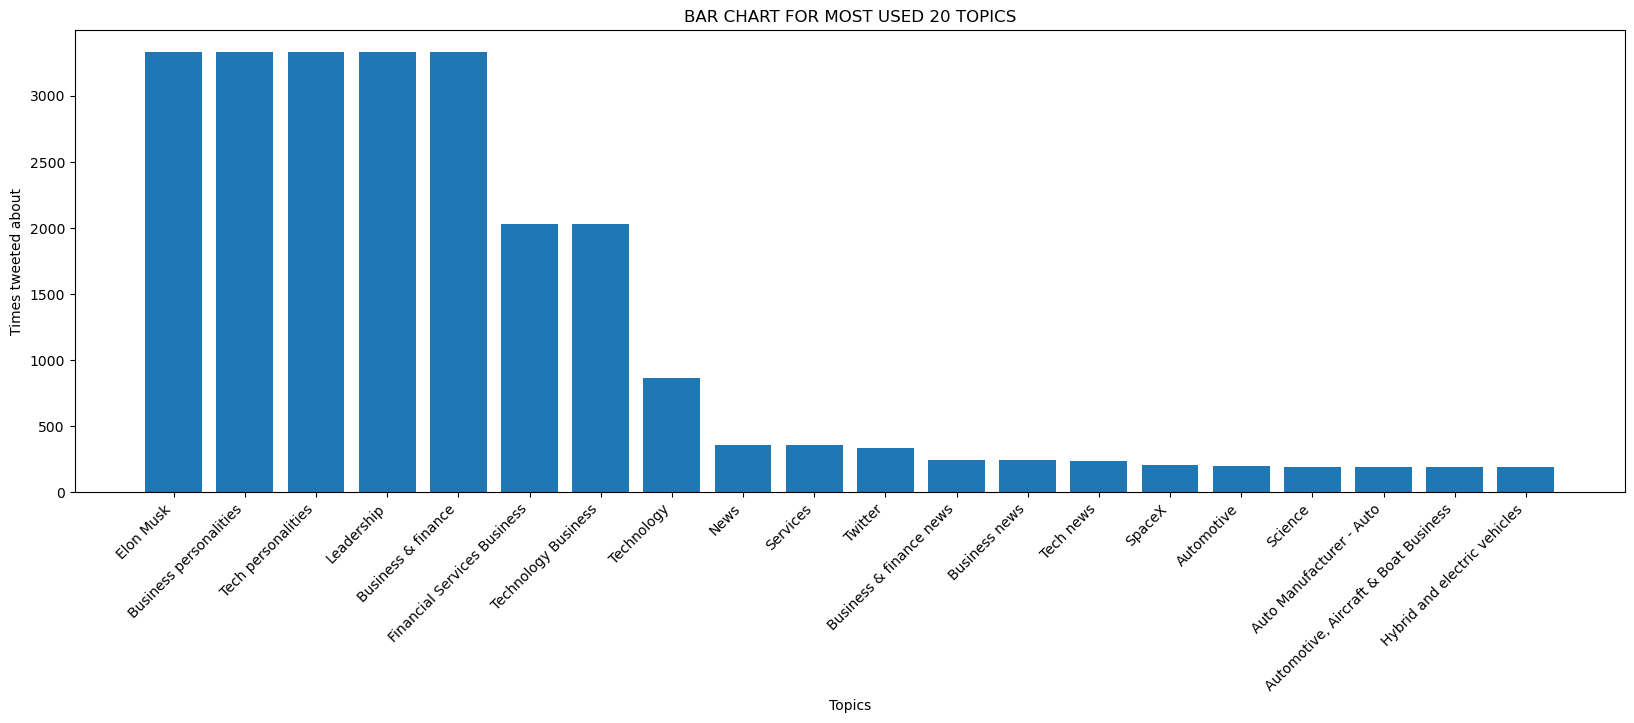

In [14]:
#Since we are dealing with categorical data, a bar chart was used 

most_used_topics = """ 
MATCH (a:Tweet)-[r:DISCUSSES]->(b:Topic) 
WHERE  a.author = $elon
RETURN b.name as name, count(r) as count_amount 
ORDER BY count_amount DESC 
LIMIT 20
"""


 
with graph.session() as session: 
    result = session.run(most_used_topics, elon=elon_id)
    
    topics = [] 
    amount = [] 
    for res in result:
        topics.append(res['name'])
        amount.append(res['count_amount'])
    
    plt.rcParams["figure.figsize"] = (20,6) #generate the bar chart 
    plt.bar(topics, amount)
    plt.xticks(rotation=45, ha='right')
    plt.title("BAR CHART FOR MOST USED 20 TOPICS")
    plt.xlabel("Topics")
    plt.ylabel("Times tweeted about")
    plt.show()

### Most used words + a visualisation 

In [15]:
from nltk.tokenize import * 
from nltk.probability import FreqDist
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

get_text_from_tweets = """ 
MATCH (a:Tweet) 
WHERE a.author = $elon
RETURN a.content as text 
"""

string = "" 

with graph.session() as session: 
    result = session.run(get_text_from_tweets, elon=elon_id)
    
    
    for res in result:
         string += res['text']            

#begin natural language processing 

tokenizer = RegexpTokenizer(r'\w+') #tokenizer for words 
words = tokenizer.tokenize(string.lower()) #tokenize the words 
filtered_words = [word for word in words if word not in stopwords.words('english')] #filter english only words 

porter = PorterStemmer() 
wordnet = WordNetLemmatizer() 

stem_list = [] 
lemma_list = [] 

for word  in filtered_words: 
    stem_list.append(porter.stem(word)) #getting stem of word 
    lemma_list.append(wordnet.lemmatize(word)) #getting lemma 

fdist = FreqDist(stem_list) #get frequency distributions 
fdist1 = FreqDist(lemma_list)

print(len(fdist))
print(len(fdist1))

6040
6911


(1.0, 489.0)

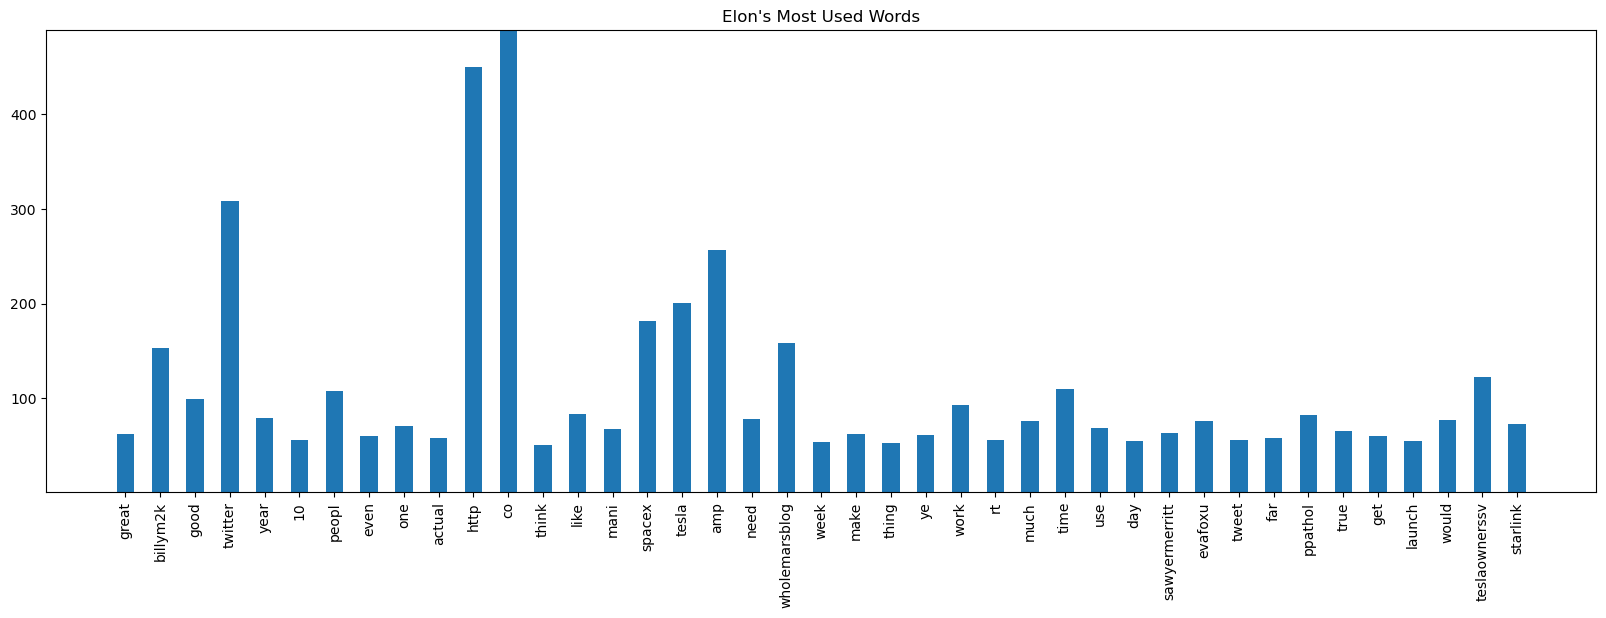

In [16]:
key_val_words = {k:v for k,v in fdist.items() if v>50} #only consider words occuring more than v times 

X = np.arange(len(key_val_words)) #get x and y 
Y = list(key_val_words.values())

#bar chart 
plt.title('Elon\'s Most Used Words')
plt.bar(X, Y, align='center', width = 0.5)
plt.xticks(X, key_val_words.keys(), rotation='vertical')
ymax = max(Y) + 1 
plt.ylim(1, ymax)

# A link between @dr_jpe to @elon_musk through tweet (with a visual)

In [17]:
with open('Raw_Data_Wayne/jpe_tweets.json') as file: #TODO switch out with proper file 
    jpe_tweets = json.load(file)

with graph.session() as load_tweets: 
    for obj in jpe_tweets: #for each tweet 
        load_tweets.execute_write(create_tweet, obj)#create a node 
        load_tweets.execute_write(create_tweet_stats, obj['id'], obj['public_metrics'])#link it's stats 
        
        if 'context_annotations' in obj.keys():
            load_tweets.execute_write(create_tweet_topics, obj['id'], obj['context_annotations'])#and it's topics 
        if 'entities' not in obj.keys():
            continue            
        if 'mentions' not in obj['entities'].keys():
            continue 
            
        load_tweets.execute_write(create_tweet_mentions, obj['id'], obj['entities']['mentions'])#and the mentions when they exist
                
with graph.session() as load_users: #link jpe to all his tweets 
    load_users.execute_write(create_person, jpe_tweets[0]['author_id'], "Jean-Paul Ebejer", "dr_jpe")
    load_users.execute_write(tweeted, jpe_tweets[0]['author_id'])      

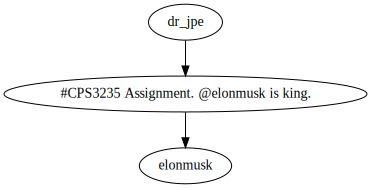

In [22]:
from graphviz import Digraph 


link = """ 
MATCH p = shortestpath((a:User)-[*]->(b:Mention))
WHERE a.u_id = $jpe AND b.name = $elon 
RETURN NODES(p) AS node 
"""

with graph.session() as session:
    results = session.run(link, jpe=jpe_tweets[0]['author_id'], elon="elonmusk")
    
    counter = 0 
    node_list = [] 
    dot = Digraph() 
    
    #form a link between dr_jpe and elon 
    for res in results:
        for node in res['node']:

            node_dict = dict(node)
            
            if counter == 0: 
                node_list.append(node_dict['username'])
            
            if counter == 1: 
                node_list.append(node_dict['content'])
                dot.edge(node_list[counter-1], node_list[counter])
                
            if counter == 2:
                node_list.append(node_dict['name'])
                dot.edge(node_list[counter-1], node_list[counter])
                
            counter += 1 
        
dot     